# Project for Cognitive Modelling

We want to reconstruct the z-values given only the rgb-values (grayscale in this case) and a lightsource

In [1]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import numpy as np
import scipy.optimize as opt

## Define surface

In [2]:
grid_size = (20,20)

xx, yy = np.meshgrid(np.linspace(-2,2,grid_size[0]),np.linspace(-2,2,grid_size[1]))
zz = np.zeros(grid_size) 
inner = -xx**2 - yy**2 + 1
zz_s = np.sqrt(inner[inner>=0]) 
zz[inner>=0] = zz_s

## Add lightsource

In [3]:
greyscale = np.ones((grid_size[0],grid_size[1],3))
grey = 0.7
color = greyscale*grey

start_azimuth = 0
start_elevation = 45

light = LightSource(start_azimuth,start_elevation) # azimuth (rotation), elevation
illuminated_surface = light.shade_rgb(color,zz)
illumination = illuminated_surface[:,:,0]

## Plot figure

<IPython.core.display.Javascript object>


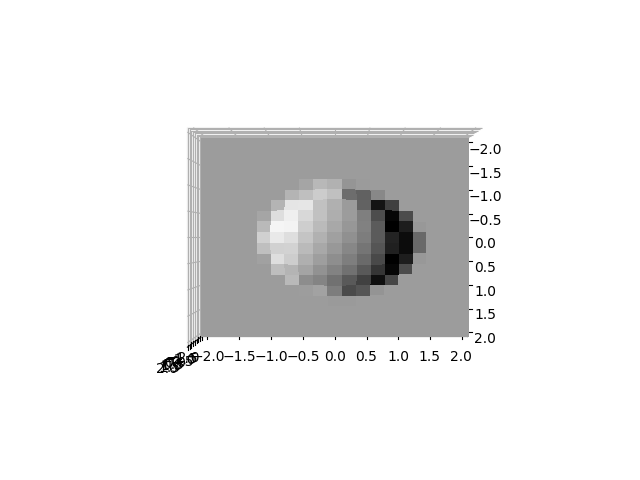

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

In [5]:
def ml_loss(zz_guess):
    zz_guess = np.reshape(zz_guess,grid_size)
    il_s = light.shade_rgb(color,zz_guess)
    il_guess = il_s[:,:,0]
    r = (il_guess-illumination).ravel()
    return np.log(r.dot(r))

def ml_loss_multi_light(zz_guess,lights,alpha=0.5):
    zz_guess = np.reshape(zz_guess,grid_size)
    il_guess = light.shade_rgb(color,zz_guess)[:,:,0]
    r = (il_guess-illumination).ravel()
    loss_single = r.dot(r)
    loss_multi = 0
    for l in lights:
        il_guess = l.shade_rgb(color,zz_guess)[:,:,0]
        r = (il_guess-illumination).ravel()
        loss_multi += r.dot(r)
    return np.log(loss_single + alpha*(loss_multi/len(lights)))

def ml_loss_multi_view(zz_guess,ill_org,light_org,ill_sec,light_sec):
    zz_guess = np.reshape(zz_guess,grid_size)
    il_guess = light_org.shade_rgb(color,zz_guess)[:,:,0]
    r = (il_guess-ill_org).ravel()
    org_loss = r.dot(r)
    il_guess = light_sec.shade_rgb(color,zz_guess)[:,:,0]
    r = (il_guess-ill_sec).ravel()
    sec_loss = r.dot(r)
    return np.log(org_loss+sec_loss)

def evaluate_guess(guess,target):
    r = (guess-target).ravel()
    return np.log(r.dot(r))

## ML estimation

In [58]:
init_guess = np.random.randn(*grid_size)
bounds = []
for i in range(int(grid_size[0]*grid_size[1])):
    bounds.append([0,1])
#res = opt.fmin_bfgs(ml_loss,init_guess.ravel(),maxiter=10000)
res,f,d = opt.fmin_l_bfgs_b(func=ml_loss,x0=init_guess.ravel(),approx_grad=True,bounds=bounds,maxiter=1000,maxfun=1e5)
print("loss: {}".format(f))
for k in d:
    if k != "grad":
        print("{}: {}".format(k,d[k]))

zz_guess = np.reshape(res,grid_size)
illuminated_surface_guess = light.shade_rgb(color,zz_guess)
evaluate_guess(zz_guess,zz)

loss: -8.28044500136397
task: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
funcalls: 100250
nit: 215
warnflag: 1


3.4096841030854916

## 2D plot of reconstruction and original

<IPython.core.display.Javascript object>


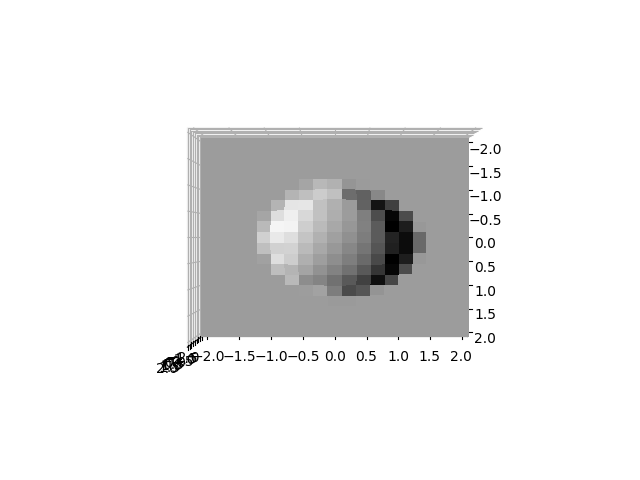

<IPython.core.display.Javascript object>


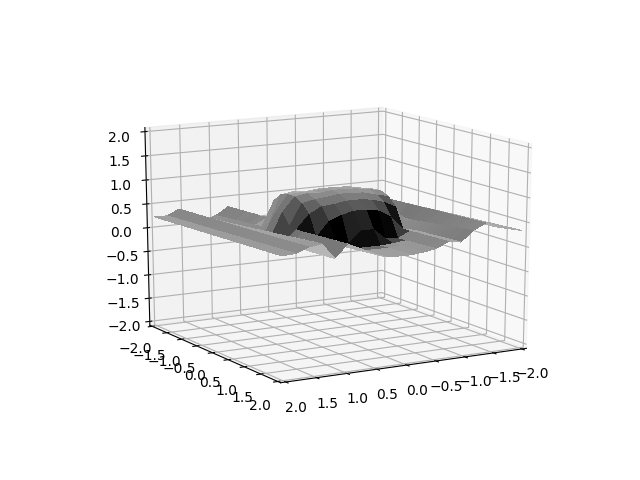

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz_guess,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface_guess)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(15,60) # elevation, azimuth (rotation)

## 3D plot of reconstruction

<IPython.core.display.Javascript object>


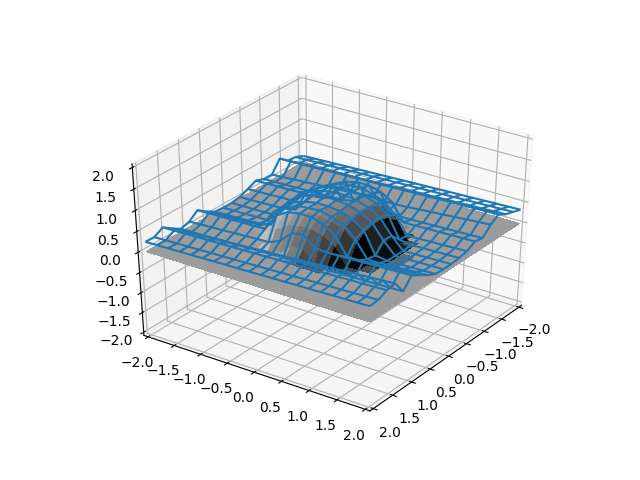

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.plot_wireframe(xx,yy,zz_guess,rstride=1,cstride=1)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(35,35) # elevation, azimuth (rotation)

## ML with multiple light sources

In [33]:
angles = 20*np.random.randn(5,)
lights = []
for angle in angles:
    lights.append(LightSource(start_azimuth+angle,start_elevation)) # azimuth (rotation), elevation

init_guess = np.random.randn(*grid_size)
bounds = []
for i in range(int(grid_size[0]*grid_size[1])):
    bounds.append([0,1])
    
alpha = 0.5

#res = opt.fmin_bfgs(ml_loss_multi_light,init_guess.ravel(),args=(lights,),maxiter=10000)
res,f,d = opt.fmin_l_bfgs_b(func=ml_loss_multi_light,x0=init_guess.ravel(),args=(lights,alpha),approx_grad=True,
                            bounds=bounds,maxiter=1000,maxfun=1e5)
print("loss: {}".format(f))
for k in d:
    if k != "grad":
        print("{}: {}".format(k,d[k]))

zz_guess = np.reshape(res,grid_size)
illuminated_surface_guess = light.shade_rgb(color,zz_guess)

loss: -2.4006922917999574
task: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
funcalls: 100651
nit: 217
warnflag: 1


## 2D plot of reconstruction and original

<IPython.core.display.Javascript object>


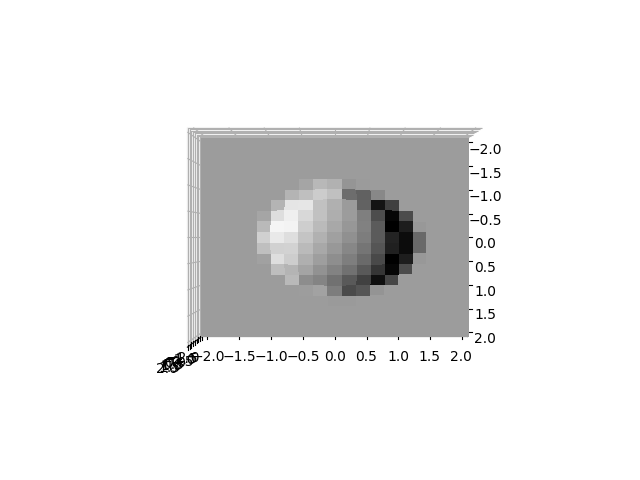

<IPython.core.display.Javascript object>


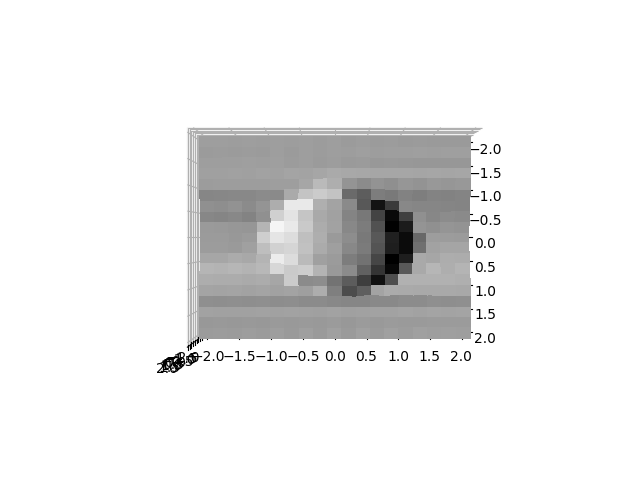

-21.65279279163523

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz_guess,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface_guess)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

evaluate_guess(zz+0.000001*np.random.randn(*grid_size),zz)

## 3D plot of reconstruction

<IPython.core.display.Javascript object>


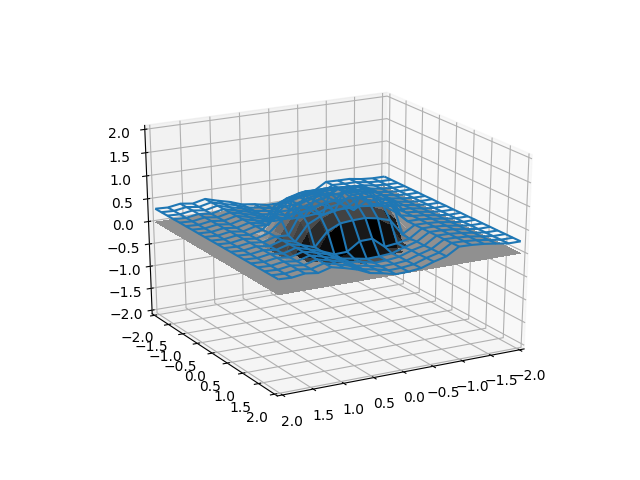

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.plot_wireframe(xx,yy,zz_guess,rstride=1, cstride=1)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(35,35) # elevation, azimuth (rotation)

## Run multiple models and compare evaluation loss

In [53]:
num_lights = np.array([1,2,3,4])
num_inits = 5
alpha = 0.5
bounds = []
for i in range(int(grid_size[0]*grid_size[1])):
    bounds.append([0,1])

train_losses = np.zeros((num_lights.shape[0]))
eval_losses = np.zeros((num_lights.shape[0]))
guesses = np.zeros((grid_size[0],grid_size[1],num_lights.shape[0]))
train_loss = np.zeros((num_inits))
eval_loss = np.zeros((num_inits))
guess = np.zeros((grid_size[0],grid_size[1],num_inits))

for i,nb in enumerate(num_lights): 
    # note the actual number of lights is "i+1" (since the original light is not included in "i")
    for run in range(num_inits):
        angles = 30*np.random.randn(nb,)
        lights = []
        for angle in angles:
            lights.append(LightSource(start_azimuth+angle,start_elevation)) # azimuth (rotation), elevation
        init_guess = np.random.randn(*grid_size)
        res,f,d = opt.fmin_l_bfgs_b(func=ml_loss_multi_light,x0=init_guess.ravel(),args=(lights,alpha),approx_grad=True,
                                    bounds=bounds,maxiter=1000,maxfun=1e5)
        zz_guess = np.reshape(res,grid_size)
        train_loss[run] = f
        eval_loss[run] = evaluate_guess(zz_guess,zz)
        guess[:,:,run] = zz_guess
    train_losses[i] = np.mean(train_loss)
    eval_losses[i] = np.mean(eval_loss)
    guesses[:,:,i] = np.mean(guess,-1)

### Plot the results

<IPython.core.display.Javascript object>


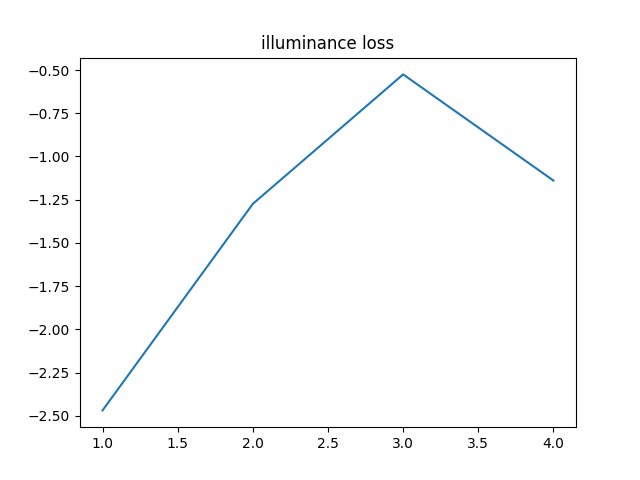

<IPython.core.display.Javascript object>


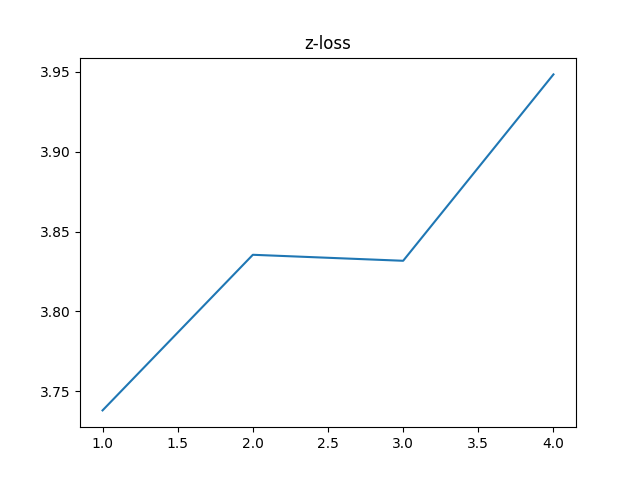

Text(0.5, 1.0, 'z-loss')

In [54]:
# smaller is better
plt.figure()
plt.plot(num_lights,train_losses)
plt.title("illuminance loss")
plt.figure()
plt.plot(num_lights,eval_losses)
plt.title("z-loss")

In [55]:
print(train_losses)
print(eval_losses)

[-2.46845829 -1.27384681 -0.52535012 -1.13932311]
[3.73796733 3.83545168 3.83169498 3.94845262]


<IPython.core.display.Javascript object>


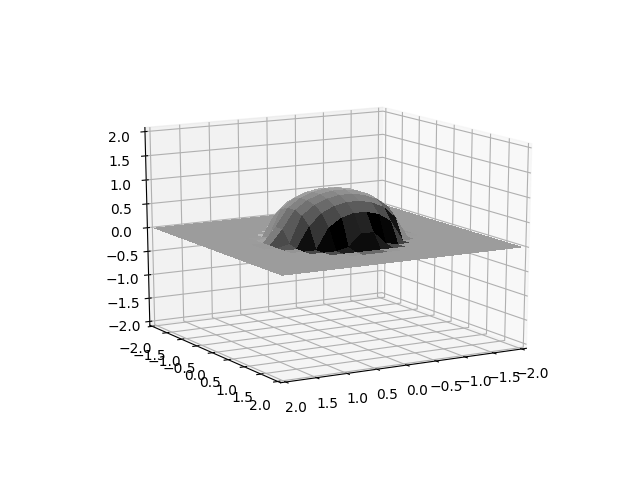

<IPython.core.display.Javascript object>


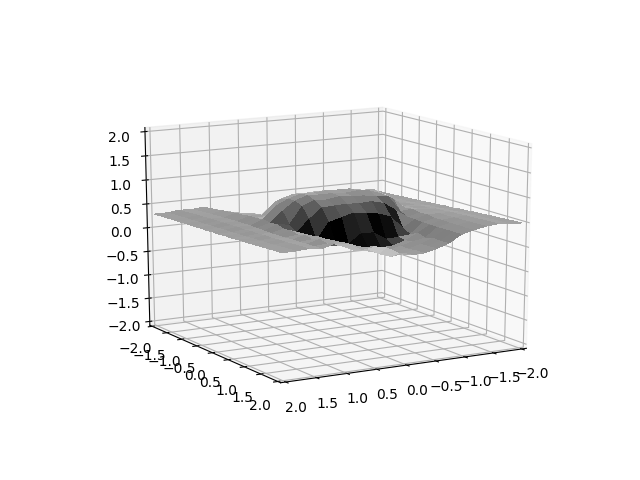

<IPython.core.display.Javascript object>


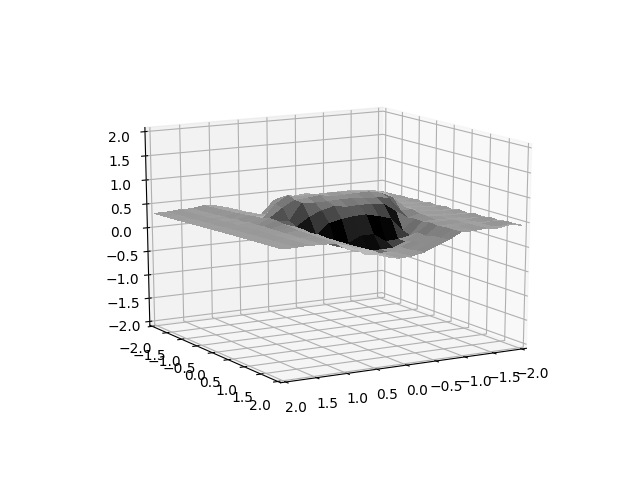

<IPython.core.display.Javascript object>


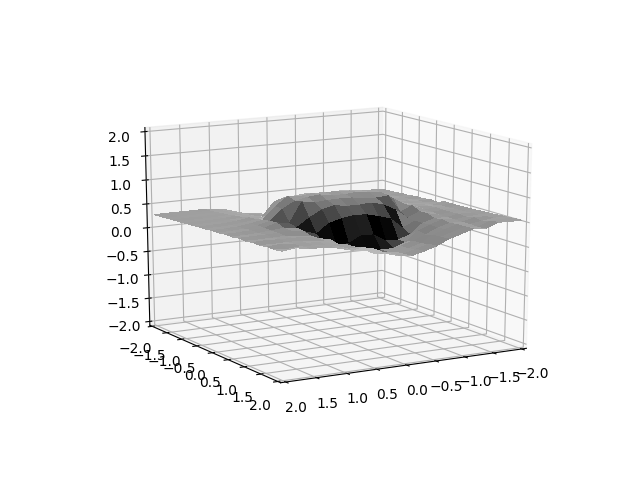

<IPython.core.display.Javascript object>


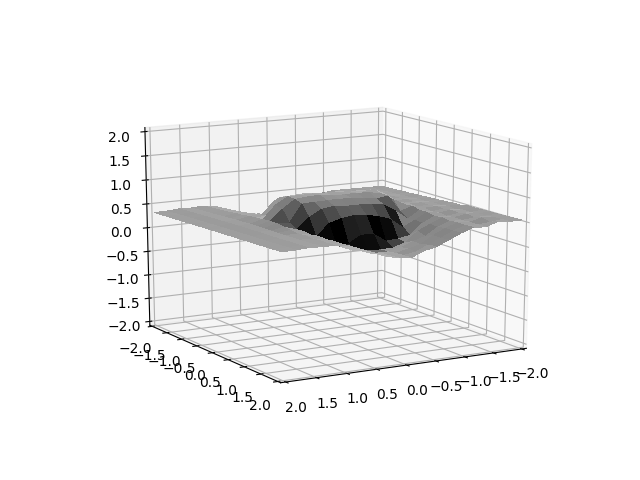

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(15,60) # elevation, azimuth (rotation)

for i,nb in enumerate(num_lights):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cur_guess = guesses[:,:,i]
    il_guess = light.shade_rgb(color,cur_guess)
    ax.plot_surface(xx,yy,cur_guess,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=il_guess)
    ax.set_xlim3d(-2,2)
    ax.set_ylim3d(-2,2)
    ax.set_zlim3d(-2,2)
    ax.view_init(15,60) # elevation, azimuth (rotation)

<IPython.core.display.Javascript object>


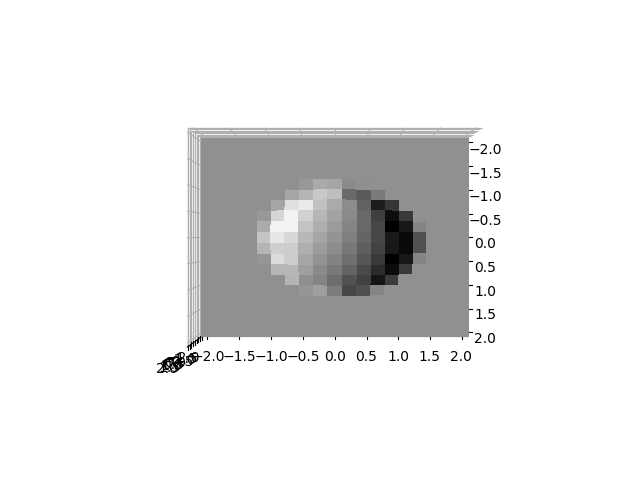

<IPython.core.display.Javascript object>


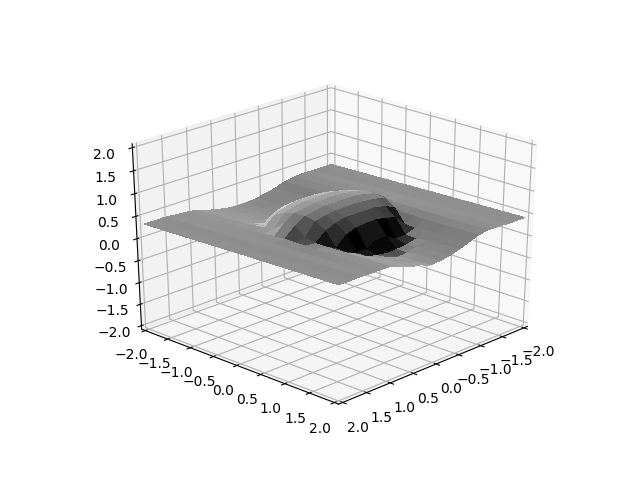

<IPython.core.display.Javascript object>


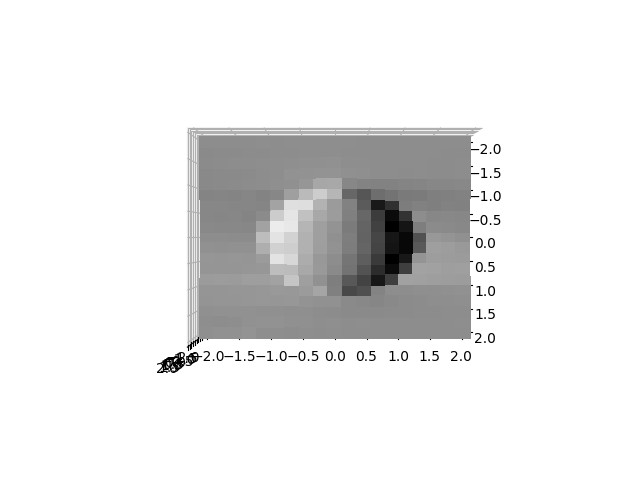

<IPython.core.display.Javascript object>


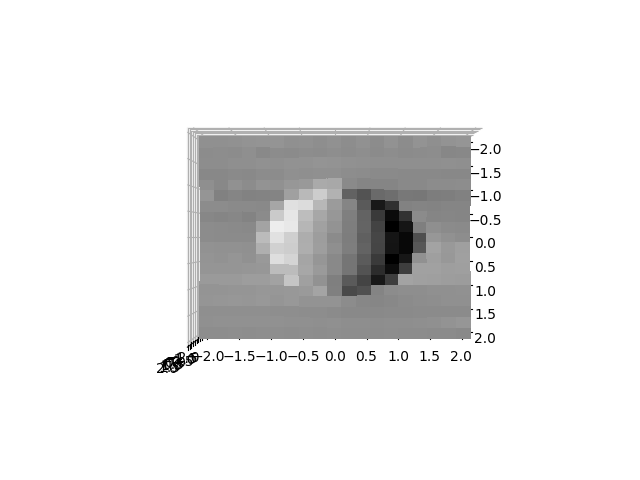

<IPython.core.display.Javascript object>


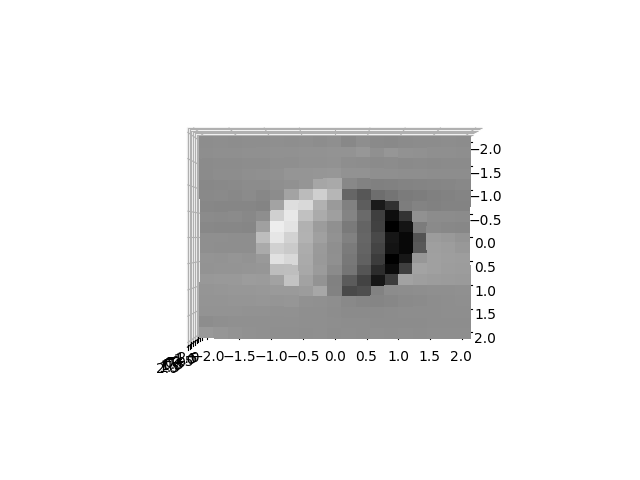

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

for i,nb in enumerate(num_lights):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cur_guess = guesses[:,:,i]
    il_guess = light.shade_rgb(color,cur_guess)
    ax.plot_surface(xx,yy,cur_guess,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=il_guess)
    ax.set_xlim3d(-2,2)
    ax.set_ylim3d(-2,2)
    ax.set_zlim3d(-2,2)
    ax.view_init(90,0) # elevation, azimuth (rotation)

In [16]:
light_sec = light = LightSource(start_azimuth+20,start_elevation) # azimuth (rotation), elevation
illuminated_surface_sec = light_sec.shade_rgb(color,zz)
ill_sec = illuminated_surface_sec[:,:,0]

init_guess = np.random.randn(*grid_size)
bounds = []
for i in range(int(grid_size[0]*grid_size[1])):
    bounds.append([0,1])
res,f,d = opt.fmin_l_bfgs_b(func=ml_loss_multi_view,x0=init_guess.ravel(),args=(illumination,light,ill_sec,light_sec),approx_grad=True,bounds=bounds,
                            maxiter=1000,maxfun=1e5)
print("loss: {}".format(f))
for k in d:
    if k != "grad":
        print("{}: {}".format(k,d[k]))

zz_guess = np.reshape(res,grid_size)
illuminated_surface_guess = light.shade_rgb(color,zz_guess)
evaluate_guess(zz_guess,zz)

loss: -0.5090977994498076
task: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
funcalls: 100250
nit: 223
warnflag: 1


3.5536193413107604

<IPython.core.display.Javascript object>


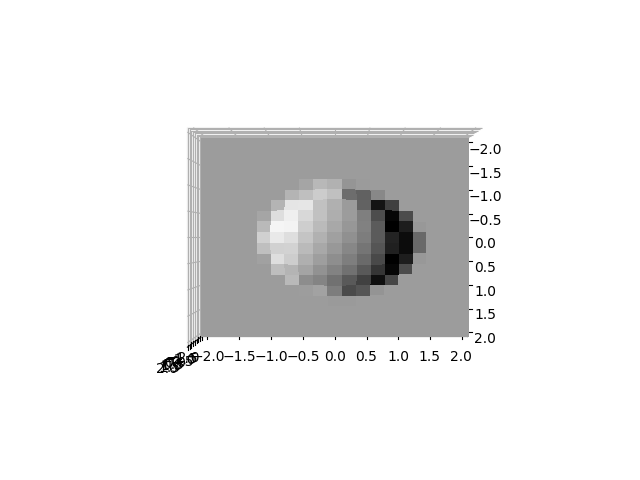

<IPython.core.display.Javascript object>


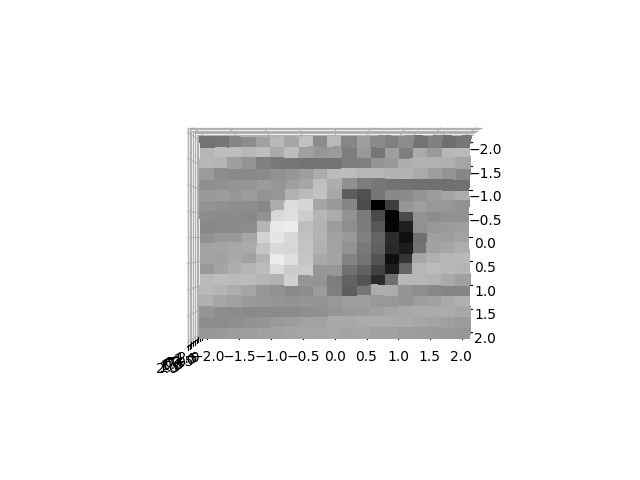

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz_guess,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface_guess)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(90,0) # elevation, azimuth (rotation)

<IPython.core.display.Javascript object>


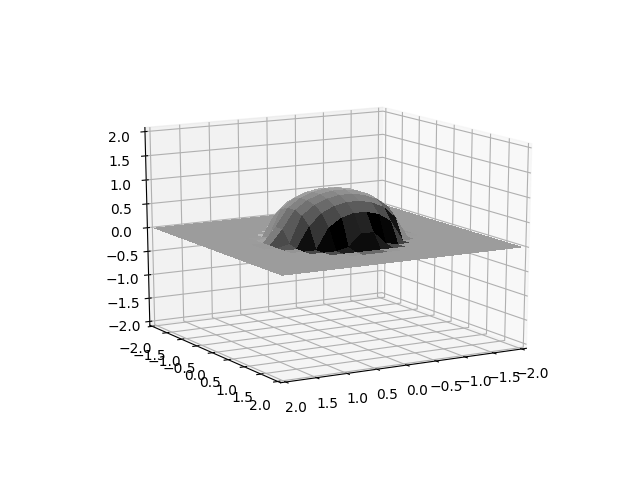

<IPython.core.display.Javascript object>


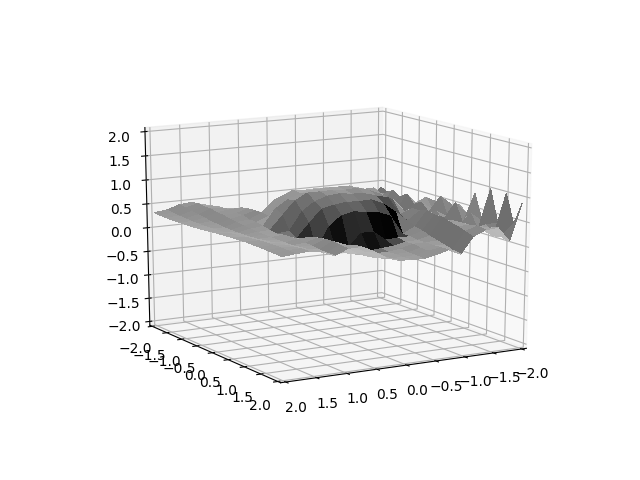

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(15,60) # elevation, azimuth (rotation)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,zz_guess,rstride=1,cstride=1,linewidth=0,antialiased=False,facecolors=illuminated_surface_guess)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.view_init(15,60) # elevation, azimuth (rotation)